<a href="https://colab.research.google.com/github/Joshua-Lemus/Tesis/blob/master/attractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  # general import
import os
import pickle
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import copy

# torch
import torch
import torch.nn as nn
import torch.optim as optim

# my own
from tasks import get_data
from myutils import *
from topology import gen_lattice, compute_dist

# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#torch options
dtype = torch.float
device = torch.device("cpu")

# SOME USEFUL DEFINITIONS
relu = lambda x : (x > 0) * x
def pr(h, b):
    if b > 1e2:
        return 1. * (h > 0)
    else:
        return np.exp(b * h) / (2 * np.cosh(b * h))

## Set task

### Available task:

Random Tasks:
- __RANDOM__ : random iid gaussian inputs mapped to random binary outputs
- __RANDOM-Y__ : random iid gaussian inputs mapped to random gaussian outputs
- __NLGP__ : spatially correlated inputs with output labels defined by their correlation length
- __RANDOM-FF-Teacher__: random Feed Forward teacher networkm with two layers with binary output
- __RANDOM-FF-Teacher-Y__: random Feed Forward teacher network with two layers with continuous output
- __RANDOM-RNN-Teacher__ : random Recurrent teacher network with binary output
- __RANDOM-RNN-Teacher-X__ : random Recurrent teacher network targets defined as steady state activities
- __RANDOM-RNN-Teacher-Y__ : random Recurrent teacher network with continuous output


Datasets:
- __MNIST1D__
- __MNIST__
- __MNIST10__
- __FashionMNIST__
- __CIFAR10__
- __CIFAR100__

In [ ]:
# SET MAIN PARAMS

# Pars() initializes a Class with definitions for parameters
pars = Pars()

## random task name
# pars.dataset = "RANDOM"
# pars.dataset = "RANDOM-Y"
pars.dataset = "NLGP"
# pars.dataset = "RANDOM-FF-Teacher"
# pars.dataset = "RANDOM-FF-Teacher-Y"
# pars.dataset = "RANDOM-RNN-Teacher"
# pars.dataset = "RANDOM-RNN-Teacher-X"
# pars.dataset = "RANDOM-RNN-Teacher-Y"

## dataset name
# pars.dataset = "MNIST1D"
# pars.dataset = "MNIST"
# pars.dataset = "MNIST10"
# pars.dataset = "FashionMNIST"
# pars.dataset = "CIFAR10"
# pars.dataset = "CIFAR100"

## random dataset options
pars.alpha_train = 0.1 # fraction of training patterns wrt N in a random task
pars.alpha_test = 0.1 # fraction of test patterns wrt N in a random task
pars.span_h = False # generate all h in range (only makes sense for N=2 or N=3)
pars.exp_input = False # exponentially distributed input (default is gaussian)
pars.rho = 0. # input covariance

## teacher-student FF options
pars_teacher = {}
# pars_teacher["K"] = 1 # number of hidden units in the random teacher
# pars_teacher["nonlinearity"] = "linear" # activation function : sigmoid | tanh | erf | relu | linear
# pars_teacher["g_bias_in"] = 0. # gain for biases initialization
# pars_teacher["soft_w"] = True # constant output weights
# pars_teacher["num_out"] = 1 # number of output units
# pars_teacher["g"] = 1. # gain of ff weights
# pars_teacher["J"] = None # optionally make your own kind of teacher
# pars.pars_teacher = pars_teacher

# ## teacher-student RNN options
# pars_teacher = {}
# pars_teacher["K"] = 40 # number of hidden units in the random teacher
# pars_teacher["nonlinearity"] = "relu" # activation function : sigmoid | tanh | erf | relu | linear
# pars_teacher["discrete_time"] = False # type of temporal dynamics
# pars_teacher["dt"] = 0.1 # time discretization
# pars_teacher["eye_in"] = True # identity input weights
# pars_teacher["g_bias_in"] = 0. # gain for biases initialization
# pars_teacher["soft_w"] = False # constant output weights
# pars_teacher["num_out"] = 1 # number of output units
# pars_teacher["g"] = 0.8 # gain of recurrent weights
# pars_teacher["J"] = None # optionally make your own kind of teacher
# pars.pars_teacher = pars_teacher

## NLGP specific options
pars.torus = True # whether to use a torus topology
pars.g_nonlin = 1e-10 # gain parameter for nonlinearity
pars.xis = [2] # lenght-scales of mixtures (?)

## spatial options
pars.dim = 1 # input dimension
pars.lN = 100 # linear input dimension
pars.normalize = False # normalize inputs (some dataset are already normalized)

## misc options
pars.seed_data = 1
pars.data_dir = f'data'
pars.save_dir = f'results_notebook'

# # TO DIRECTLY DOWNLOAD MNIST1D USE THE FOLLOWING:
# import requests
# url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
# r = requests.get(url, allow_redirects=True)
# save_dir_dataset = save_dir + "/" + dataset
# open(f'{data_dir}/mnist1d_data.pkl', 'wb').write(r.content)

In [ ]:
# GET DATASET
makedir(pars.data_dir)
data_and_properties = get_data(pars, dtype=dtype, device=device)
train_dataset, test_dataset, teacher_weights, x_teacher = data_and_properties
print(f"{pars.dim} dimensional inputs of size {pars.lN}^{pars.dim} = {pars.N}")
print(f"num train: {pars.num_train}, num test: {pars.num_test}, num label: {pars.num_label}")

1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 10, num label: 1


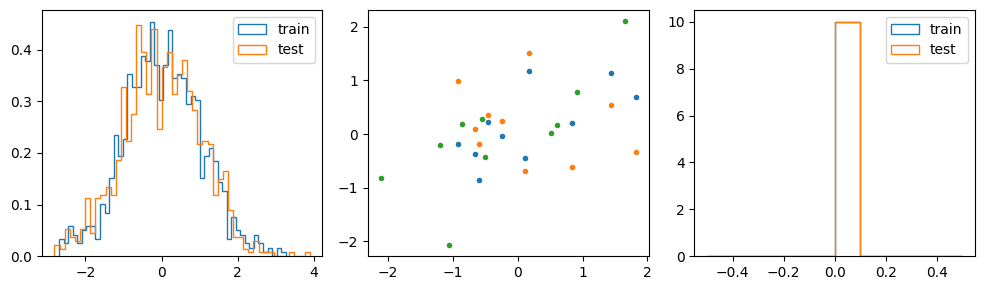

In [ ]:
# WATCH RANDOM DATA DISTRIBUTION

if "RANDOM" in pars.dataset or "GP" in pars.dataset:
    plt.figure(figsize=(10,3))

    X_to_plot_train, y_to_plot_train = extract_tensors(train_dataset)
    if pars.num_test is not None:
        X_to_plot_test, y_to_plot_test = extract_tensors(test_dataset)

    plt.subplot(131)
    plt.hist(X_to_plot_train.flatten(), bins=50, density=True, histtype="step", label="train");
    if pars.num_test is not None:
        plt.hist(X_to_plot_test.flatten(), bins=50, density=True, histtype="step", label="test");
    plt.legend();

    plt.subplot(132)
    plt.plot(X_to_plot_train[:,0], X_to_plot_train[:,1], '.');
    plt.plot(X_to_plot_train[:,0], X_to_plot_train[:,2], '.');
    if pars.num_test is not None:
     plt.plot(X_to_plot_test[:,0], X_to_plot_test[:,2], '.');

    plt.subplot(133)
    plt.hist(y_to_plot_train.flatten(), density=True, histtype="step", label="train");
    if pars.num_test is not None:
        plt.hist(y_to_plot_test.flatten(), density=True, histtype="step", label="test");
    plt.legend();

    plt.tight_layout()

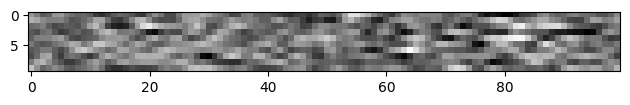

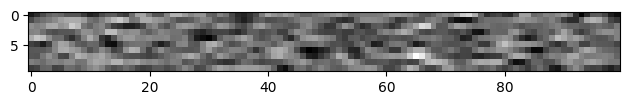

In [ ]:
# WATCH DATASET
watch_dataset(train_dataset, test_dataset, pars)

## Run learning

In [ ]:
a = gen_lattice(dim=1, lens=[10, 10], torus=True, random_pos=True, tot_points=100, centered=False)
b= a.flatten()
a == b
a.shape
#lensi=[L,L]
#for i in range(2):
  #print(i)
  #print(lensi[i])
#print(lensi[1])
#[lensi[d] for d in range(2)]
[10/2]

[5.0]

In [ ]:
# playground = gen_lattice(dim=1, lens=[5, 5], torus=True, random_pos=False, tot_points=[5,5], centered=False)
# playground
# b=compute_dist(dim=1, pos0=playground, pos1=playground, lens=[5, 5], torus=True)
# b.numpy()

In [ ]:
# 0*np.ones_like(playground)

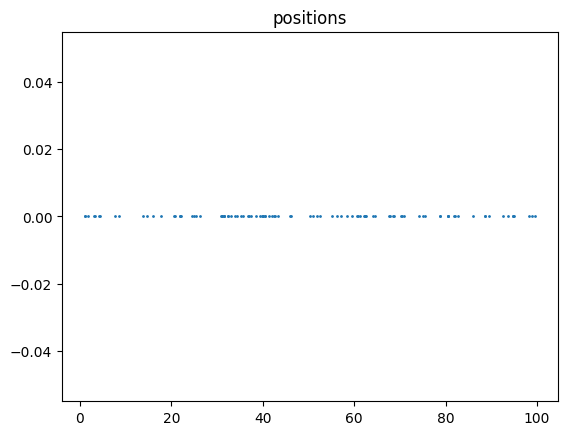

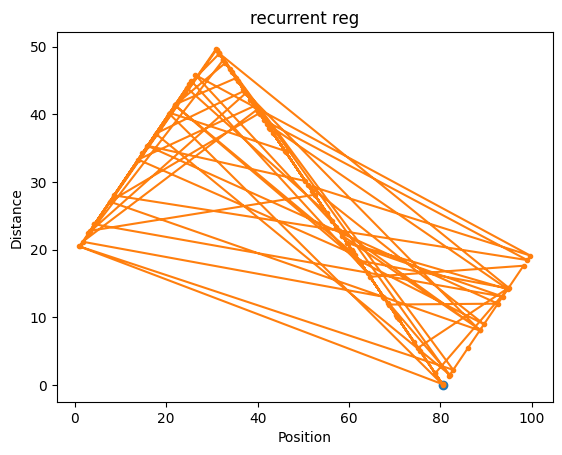

In [ ]:
# network options
lN, N = pars.lN, pars.N # Where is pars.N? (Not in myutils.py)
P = pars.num_train
fe = -1 # Fraction of excitatory links
sparsity_mean = 0. # Mean number of datapoints that will be set to 0
sparsity_std = 0.
noself = True # Neurons don't link with themselves
use_bias = True
learn_bias = True
bias = 0. # Why is
norm_dependent_stability = False
embed_model = True
dim = pars.dim
do_torus = pars.torus

# learning options
num_epochs = 200
print_every = 10
lr = 0.1 # learning rate (?)
delta0 = 0.1
gam = 0.
gam_en = 0. # Energy regularization
gam_sign = 0.5
gam_pos = 0.
relu2 = True
maxweight = 1e2
square_dist = False
stop_at_zero_err = False

# ## homogeneous sparsities
# sparsities = sparsity_mean + np.random.randn(N) * sparsity_std
# sparsities = np.clip(sparsities, a_min=0, a_max=1)
# ## space-dependent sparsities
# sparsities = np.linspace(0.9, 0.1, N)
# sparsities = np.ones(N) * 0.95
# sparsities[:N//2] = 0.15

# gen patterns (transformed versions of the data(D))
# X = 1. * (np.random.rand(P,N) <= sparsities[None])
X = 0.5 * (1 + np.sign(train_dataset.tensors[0].numpy())) # Maps thata from [-1,1] to [0,1]
Y = 2. * X - 1. # Remap from [0,1] to [-1,1] (actually, Y=D)

# if sparsity_std > 0:
#     plt.plot(sparsities, '.:')
#     plt.plot(X.mean(0), '.-')
#     plt.title('sparsities');

## init J: matrix with weight between neurons
Ne = int(fe * N) # Number of excitatory links
I = bias * np.ones(N) # Bias input (some constant input common to all(?))
# If fe == -1, initialize J from normal distribution (excitatory and inhibitory everywhere)
# else initialize J from uniform distrubition and separate Ne excitatory and N-Ne inhibitory
if fe == -1:
    J = np.random.randn(N, N) / np.sqrt(N)
else:
    J = np.random.rand(N, N) / np.sqrt(N)
    J[:,Ne:] *= -1.
# Remove the values in the diagonal (loops)
diag_indices = np.diag_indices(N)
if noself:
    J[diag_indices] = 0.

## Optionally, create a spatial embedding of the neural network
if embed_model:
    #If 1D, generate a position tensor of dimension [N]; if 2D, generate a tensor of dimension [sqrt(N), sqrt(N)]
    if dim == 1:
        L = N
        totpoints = [L]
    elif dim == 2:
        L = int(np.sqrt(N))
        if L**2 != N:
            print("WARNING: need a perfect square in dimension 2")
        totpoints = [L, L]
    else:
        raise ValueError("dim = 3 not implemented yet!")
    pos = gen_lattice(dim=dim, lens=[L,L], torus=do_torus, random_pos=True, tot_points=totpoints, centered=False)

    # Calculate distance between cells in our position tensor (farther grids should get a bigger distance)
    dist = compute_dist(dim, pos, pos, lens=[L,L], torus=do_torus, square=square_dist)
    #dist = np.tanh(dist/10) * 10
    pos = pos.numpy()
    dist = dist.numpy()

    # visualize positions
    if dim == 1:
        plt.plot(pos, 0 * np.ones_like(pos), 'o', ms=1)
        plt.title('positions')
        plt.show()

        # recurrent reg (distance between the lattice)
        i_plot = [L//2]
        for i in i_plot:
            plt.plot(pos[i], 0, 'o')
            plt.plot(pos, dist[i], '.-')
        plt.title('recurrent reg')
        plt.xlabel('Position')
        plt.ylabel('Distance')
        plt.show()

In [ ]:
#np.random.permutation(10)
#X.shape
#a=np.array([[1,2,3], [3,2,1]])
#print((a**2).sum(-1))
#a[0]*(a[1]<2)
#np.outer(a[0], a[1])
#a[0,:2]
#J[(J)<-1]
#relu(-1)
I.shape

(100,)

In [ ]:
# initialize variables
J0 = J.copy() #Save original (random) state of J before training
errs, en_regs, sign_regs, pos_regs = [], [], [], []
ok = False # Will say when to stop (at convergence)

# run optimization
for ep in range(num_epochs):

    # run through data (updating units randomly)
    perm = np.random.permutation(P) # random dynamical update
    for mu in perm:

        # compute fields
        H = J @ X[mu] # weights*data
        if use_bias:
            H += I

        # learning step
        delta = delta0 * np.sqrt((J**2).sum(-1)) if norm_dependent_stability else delta0 * np.sqrt(N)
        err = Y[mu] * ((Y[mu] * H) < delta)
        derr = np.outer(err, X[mu])
        J += lr * derr
        J -= lr * gam * J

        # train input bias
        if use_bias and learn_bias:
            I += lr * err

        # apply energy regularization
        if gam_en:
            en_reg = 0.5 * (J**2 @ X[mu]).mean()
            J -= lr * gam_en * J * X[mu][None]

        # apply sign regularization
        if gam_sign:
            if relu2:
                reluscorr = relu(-np.einsum('ki,li->kli', J, J))
                sign_reg = 0.25 * (reluscorr**2).sum() / N**2 # unused var
                dsign_reg = -np.einsum('kli,li->ki' ,reluscorr, J)
            else:
                scorr = -np.einsum('ki,li->kli', J, J)
                thetascorr = 1. * (scorr >= 0)
                sign_reg = 0.5 * (thetascorr * scorr).sum() / N**2 # unused var
                dsign_reg = -np.einsum('ijk,ji->ik', thetascorr, J)
            J -= lr * gam_sign * dsign_reg

        # apply position regularization
        if gam_pos:
            J -= lr * gam_pos * J * dist

        # enforce constraints (unless Ne==-1, because then we can't decide
        # which weights are set to 0)
        # For Ne==-1: J[(J)<-maxweight] = -maxweight, J[(J)>maxweight]=maxweight
        if Ne > -1:
            np.clip(J[:,:Ne], 0., maxweight, out=J[:,:Ne])
            np.clip(J[:,Ne:], -maxweight, 0., out=J[:,Ne:])
        if noself:
            J[diag_indices] = 0.

    # compute errors and print
    if ep % print_every == 0:

        # compute loss on entire training set
        Hs = X @ J.T
        if use_bias:
            Hs += I[None]
        err = ((Hs * Y) < delta).mean()
        errs += [err]

        # compute energy regularization
        if gam_en:
            en_reg = 0.5 * (X @ J**2).mean()
            en_regs += [en_reg]

        # compute sign regularization on J
        if gam_sign:
            reluscorr = relu(-np.einsum('ik,jk->ijk', J, J))
            if relu2:
                sign_reg = 0.25 * (reluscorr**2).sum() / N**2
            else:
                sign_reg = 0.5 * reluscorr.sum() / N**2
            sign_regs += [sign_reg]

        if gam_pos:
            pos_reg = 0.5 * (J**2 * dist).mean()
            pos_regs += [pos_reg]

        # print info
        toprint = f'ep: {ep} loss: {err}'
        if gam_en:
            toprint += f' en reg: {en_reg}'
        if gam_sign:
            toprint += f' sign reg: {sign_reg}'
        if gam_pos:
            toprint += f' pos reg: {pos_reg}'
        print(toprint)

        # optionally stop at convergence, print epoch of convergence
        if err.sum() == 0:
            if not ok:
                ep_conv = ep
                ok = True
            if stop_at_zero_err:
                break

if not ok:
    print(f'loss not zero in {ep} epochs - min av error {errs[-1]}')
else:
    print(f'zero loss converged at {ep_conv} epochs')

ep: 0 loss: 0.42 sign reg: 0.0029978358945212725
ep: 10 loss: 0.108 sign reg: 0.0010055261633383464
ep: 20 loss: 0.027 sign reg: 9.631367487417356e-05
ep: 30 loss: 0.0 sign reg: 4.806477959171232e-06
ep: 40 loss: 0.001 sign reg: 1.2725499888447064e-05
ep: 50 loss: 0.0 sign reg: 4.5360182904951114e-06
ep: 60 loss: 0.0 sign reg: 9.275704109256572e-08
ep: 70 loss: 0.0 sign reg: 3.2059604648479865e-08
ep: 80 loss: 0.0 sign reg: 1.902012063293629e-08
ep: 90 loss: 0.0 sign reg: 1.23983564233915e-08
ep: 100 loss: 0.0 sign reg: 8.506109550053636e-09
ep: 110 loss: 0.0 sign reg: 6.041471497392443e-09
ep: 120 loss: 0.0 sign reg: 4.397503056773699e-09
ep: 130 loss: 0.0 sign reg: 3.2584258772330777e-09
ep: 140 loss: 0.0 sign reg: 2.4464466571898466e-09
ep: 150 loss: 0.0 sign reg: 1.8550637158139713e-09
ep: 160 loss: 0.0 sign reg: 1.417217605464088e-09
ep: 170 loss: 0.0 sign reg: 1.0889286043635337e-09
ep: 180 loss: 0.0 sign reg: 8.403709282683399e-10
ep: 190 loss: 0.0 sign reg: 6.507516192890424e-1

Text(0, 0.5, 'Error')

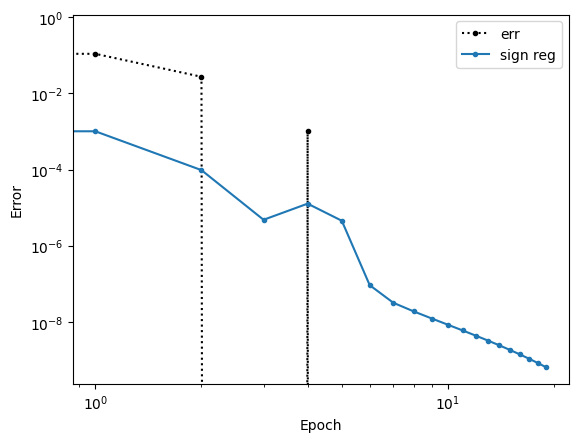

In [ ]:
plt.plot(errs, '.:', c='black', label='err');
if gam_en:
    plt.plot(en_regs, '.-', label='en reg');
if gam_sign:
    plt.plot(sign_regs, '.-', label='sign reg');
if gam_pos:
    plt.plot(pos_regs, '.-', label='pos reg');
plt.legend();

plt.xscale('log');
plt.xlabel('Epoch')
plt.yscale('log');
plt.ylabel('Error')

## Check stability of attractors by running network dynamics

In [ ]:
a=np.array([[1,2],[3,4],[5,6]])
b=np.array([[False,True],[True,False],[False,False]])
#x.shape == flip_init.shape
a[b] = 1-a[b]
#print(a)
J==J.transpose()

array([[ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

Text(0, 0.5, 'overlap fraction')

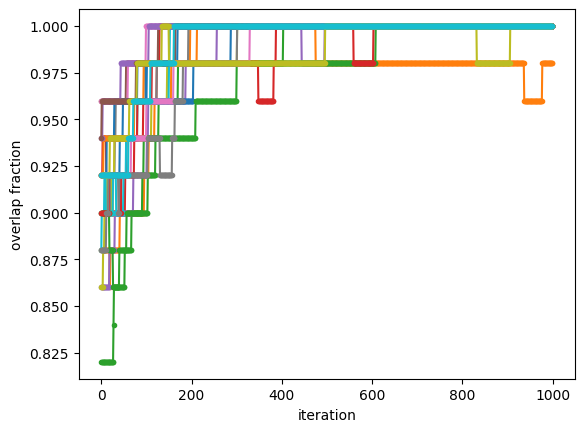

In [ ]:
# set pars
mu = 0
num_samples = 20
beta = 20
num_iter = 1000
p_flip = 0.05

### init network
x = np.tile(X[mu], num_samples).reshape(num_samples, N) # num_samples*N matrix with num_samples repetitions of X[mu]

# Flip (x->1-x) some random datapoints
flip_init = np.random.rand(num_samples, N) <= p_flip # Chose randomly indices that will flip
x[flip_init] = 1 - x[flip_init]

### run dynamics
xs = np.zeros((num_iter, num_samples, N)) # x states: retain copies of x that will be randomly flipped
for it in range(num_iter):
    # Select random nodes and flip them according on whether rand > pr(h*(2x-1)) (pr is a sigmoid or a theta)
    xs[it] = x.copy()
    h = x @ J.T + I[None] #weighted sum of inputs (total input received by a neuron)
    select = np.random.randint(N, size=num_samples)
    prob = pr(-(2. * x[range(num_samples), select] - .1) * h[range(num_samples), select], beta)
    toflip = np.random.rand(num_samples) < prob
    x[toflip, select[toflip]] = 1 - x[toflip, select[toflip]]

### compute and plot overlaps
# overlap considered over x (flipped )
ov = np.einsum('tmi,i->mt', 2*xs-1, 2*X[mu]-1) / N

plt.plot(ov.T, '.-');
plt.xlabel('iteration')
plt.ylabel('overlap fraction')


## Analysis

### Total fields before and after training

Before training:
delta_minus: 2.5814600172912763
delta_plus: -2.142290783137209

After training:
delta_minus: -1.0242551681806675
delta_plus: 1.0081116567868098


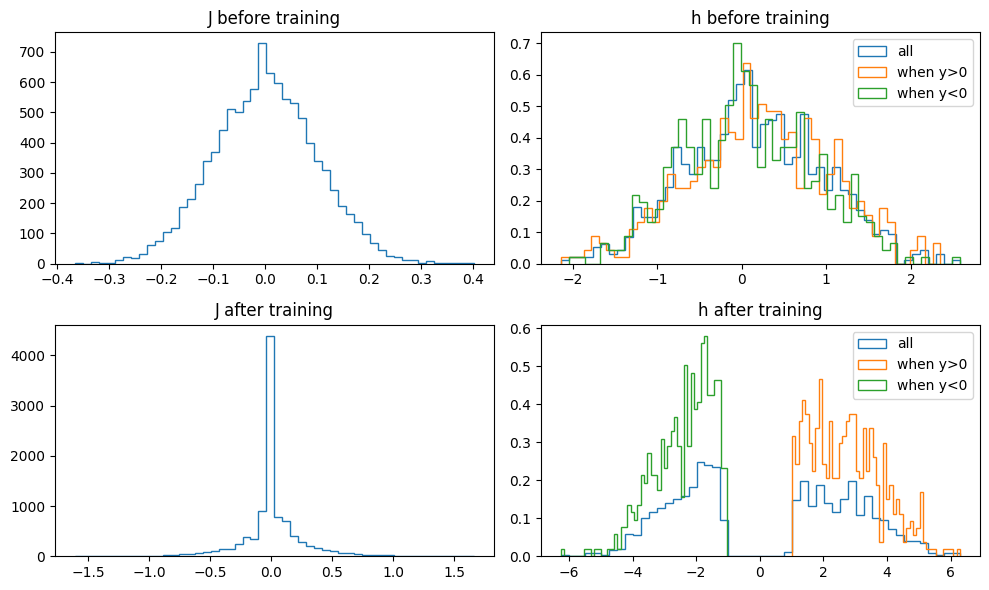

In [ ]:
plt.figure(figsize=(10,6))

### before training
Hs0 = X @ J0.T + I[None]
delta_minus0 = np.max(Hs0[Y<0]) #Most positive value when input data is negative
delta_plus0 = np.min(Hs0[Y>0]) #Most negative value when input data is positive
print("Before training:")
print("delta_minus:", delta_minus0)
print("delta_plus:", delta_plus0)
#
plt.subplot(221)
plt.hist(J0.flatten(), bins=50, histtype="step");
plt.title('J before training')
#
plt.subplot(222)
plt.hist(Hs0.flatten(), bins=50, density=True, histtype="step", label='all');
plt.hist(Hs0[Y>0], bins=50, density=True, histtype="step", label='when y>0');
plt.hist(Hs0[Y<0], bins=50, density=True, histtype="step", label='when y<0');
plt.title('h before training')
plt.legend();

### after training
Hs = X @ J.T + I[None]
delta_minus = np.max(Hs[Y<0]) #Most positive value when input data is negative
delta_plus = np.min(Hs[Y>0]) #Most negative value when input data is positive
print("\nAfter training:")
print("delta_minus:", delta_minus)
print("delta_plus:", delta_plus)

plt.subplot(223)
plt.hist(J.flatten(), bins=50, histtype="step");
plt.title('J after training')
plt.subplot(224)
plt.hist(Hs.flatten(), bins=50, density=True, histtype="step", label='all');
plt.hist(Hs[Y>0], bins=50, density=True, histtype="step", label='when y>0');
plt.hist(Hs[Y<0], bins=50, density=True, histtype="step", label='when y<0');
plt.title('h after training')
plt.legend();

plt.tight_layout();

### Effective signs for the recurrent weights

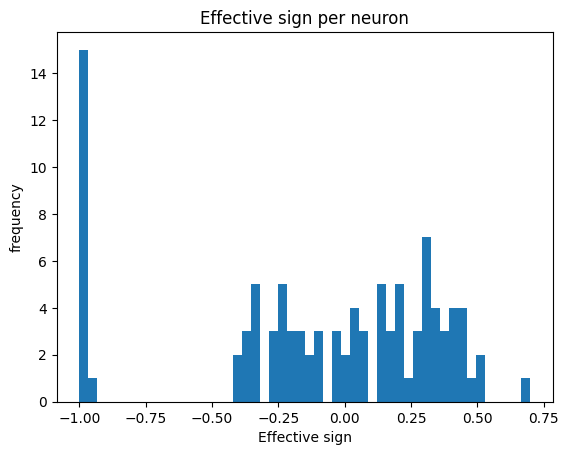

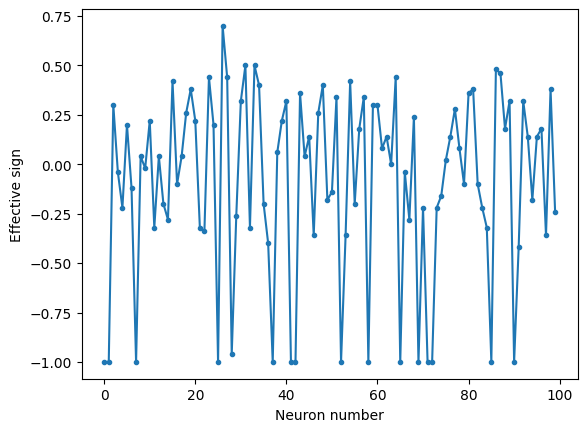

fraction of effectively positive neurons: 0.51
mean J_eff:
JEE: 0.12842436827704742
JEI: -0.12401535502436029
JIE: 0.13685339641254737
JII: -0.13917028625802141
[[ 0.12842437 -0.12401536]
 [ 0.1368534  -0.13917029]]
I_eff:
I_E:0.007843137371773813
I_I:0.007843137371773813
[0.00784314 0.19795919]


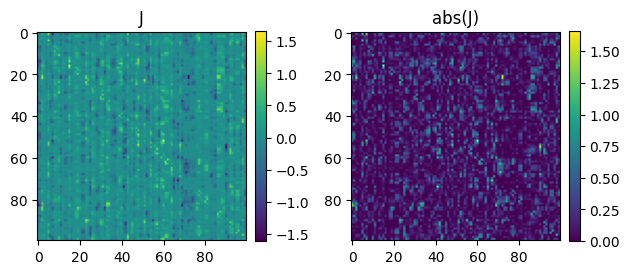

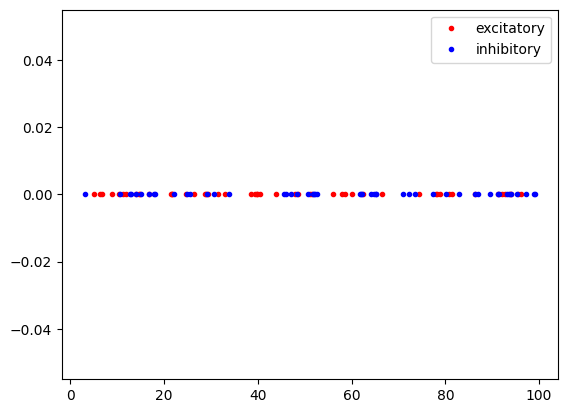

In [ ]:
## Poorly defined quantity: must probably find a better one that filters out zero weights
#Sums -1 for each negative weight, but sums wij for each positive weight
signJ = (2. * (J > 0.) - 1.).mean(0)

if fe > 0:
    indE = range(Ne)
    indI = range(Ne,N)
else:
    indE = np.arange(N)[signJ > 1e-6]
    indI = np.arange(N)[signJ <= 1e-6]

plt.hist(signJ, bins=50);
plt.xlabel('Effective sign')
plt.title('Effective sign per neuron')
plt.ylabel('frequency')
plt.show()

plt.plot(signJ, '.-');
plt.xlabel('Neuron number')
plt.ylabel('Effective sign')
plt.show()

Ne_eff = (signJ>0).sum()
Ni_eff = N - Ne_eff
fe_eff = Ne_eff / N
print('fraction of effectively positive neurons:', fe_eff)


JEE = J[indE][:,indE]
JEI = J[indE][:,indI]
JIE = J[indI][:,indE]
JII = J[indI][:,indI]

J_eff = np.array([[JEE.mean(), JEI.mean()],
                 [JIE.mean(), JII.mean()]])
print("mean J_eff:")
print(f"JEE: {J_eff[0,0]}")
print(f"JEI: {J_eff[0,1]}")
print(f"JIE: {J_eff[1,0]}")
print(f"JII: {J_eff[1,1]}")
print(J_eff)

I_eff = np.array([I[indE].mean(), I[indI].mean()])
print("I_eff:")
print(f"I_E:{I_eff[0]}")
print(f"I_I:{I_eff[0]}")
print(I_eff)

# If we have a spatial embedding, we can analyse the
if embed_model:
    plt.subplot(121)
    plt.imshow(J, origin='upper');
    plt.title('J')
    plt.colorbar(fraction=0.046, pad=0.04) #Values for fraction and pad found on SO: https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    plt.subplot(122)
    plt.imshow(np.abs(J), origin='upper');
    plt.title('abs(J)')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout();
    plt.show()

    if dim == 1:
        plt.plot(pos[indE], 0 * np.ones_like(pos[indE]), 'o', ms=3, c='red', label='excitatory')
        plt.plot(pos[indI], 0 * np.ones_like(pos[indI]), 'o', ms=3, c='blue', label='inhibitory')
        plt.legend(loc='best')
        plt.show()
    else:
        plt.imshow(np.sign(signJ).reshape(lN,lN))

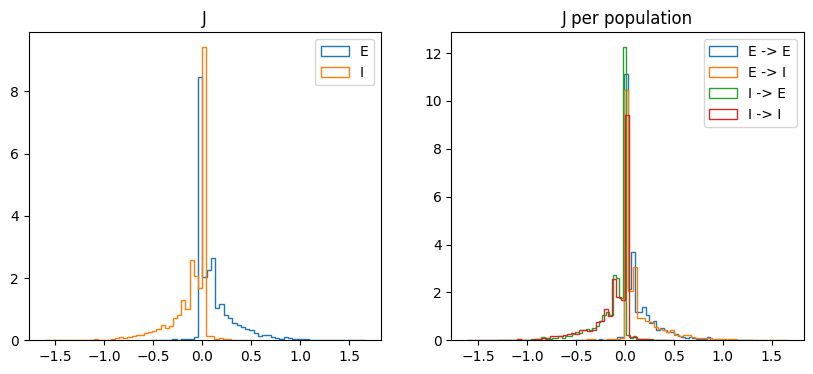

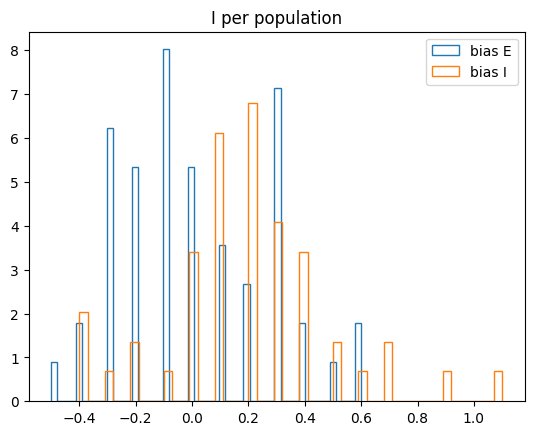

In [ ]:
### weights per population
# plot histograms for excitatory, inhibitory, E->E, E->I, I->E and I->I weights

if fe == -1 and not gam_sign:
    plt.hist(J.flatten(), bins=50, density=True, histtype="step", label='J');
#     plt.hist(I, bins=50, density=True, histtype="step", label='bias');
    plt.legend();
else:
    plt.figure(figsize=(10,4))

    plt.subplot(121)
    plt.hist(J[:,indE].flatten(), bins=50, density=True, histtype="step", label='E');
    plt.hist(J[:,indI].flatten(), bins=50, density=True, histtype="step", label='I');
    plt.title('J')
    plt.legend()

    plt.subplot(122)
    plt.hist(J[indE][:,indE].flatten(), density=True, bins=50, histtype="step", label="E -> E");
    plt.hist(J[indI][:,indE].flatten(), density=True, bins=50, histtype="step", label="E -> I");
    plt.hist(J[indE][:,indI].flatten(), density=True, bins=50, histtype="step", label="I -> E");
    plt.hist(J[indI][:,indI].flatten(), density=True, bins=50, histtype="step", label="I -> I");
    plt.title('J per population')
    plt.legend();

    plt.show()
    plt.hist(I[indE], bins=50, density=True, histtype="step", label='bias E');
    plt.hist(I[indI], bins=50, density=True, histtype="step", label='bias I');
    plt.title('I per population')
    plt.legend();

### Look at receptive and projective fields

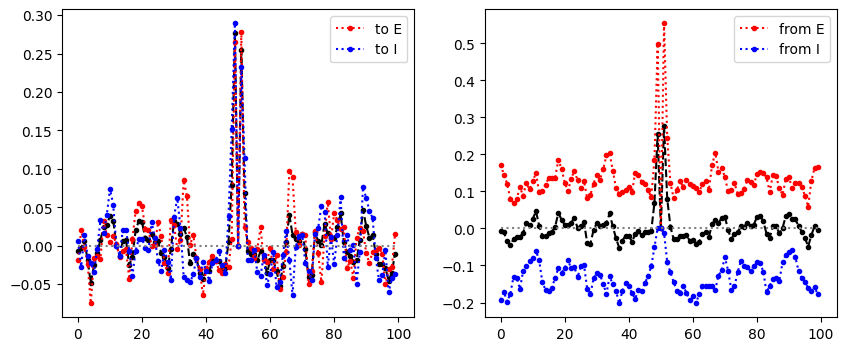

In [ ]:
Jmeanto = np.zeros(N)
Jmeanfrom = np.zeros(N)
JmeantoE = np.zeros(N)
JmeantoI = np.zeros(N)
JmeanfromE = np.zeros(N)
JmeanfromI = np.zeros(N)

for k in range(N):
    Jmeanto += np.roll(J[k], -k+N//2) * 1/N
    Jmeanfrom += np.roll(J[:,k], -k+N//2) * 1/N
    if k in indE:
        JmeantoE += np.roll(J[k], -k+N//2) / Ne_eff
        JmeanfromE += np.roll(J[:,k], -k+N//2) / Ne_eff
    if k in indI:
        JmeantoI += np.roll(J[k], -k+N//2) / Ni_eff
        JmeanfromI += np.roll(J[:,k], -k+N//2) / Ni_eff

plt.figure(figsize=(10,4))

if dim == 1:
    plt.subplot(121)
    plt.plot(Jmeanto, '.--', c='k', );
    plt.plot(JmeantoE, '.:', c='red', label='to E');
    plt.plot(JmeantoI, '.:', c='blue', label='to I');
    plt.hlines(y=0, xmin=0, xmax=N, color='gray', ls=':');
    plt.legend();

    plt.subplot(122)
    plt.plot(Jmeanfrom, '.--', c='k');
    plt.plot(JmeanfromE, '.:', c='red', label='from E');
    plt.plot(JmeanfromI, '.:', c='blue', label='from I');
    plt.hlines(y=0, xmin=0, xmax=N, color='gray', ls=':');

    plt.legend();
else:
    plt.subplot(231)
    plt.imshow(Jmeanto.reshape(lN,lN))
    plt.subplot(232)
    plt.imshow(JmeantoE.reshape(lN,lN))
    plt.subplot(233)
    plt.imshow(JmeantoI.reshape(lN,lN))

    plt.subplot(234)
    plt.imshow(Jmeanfrom.reshape(lN,lN))
    plt.subplot(235)
    plt.imshow(JmeanfromE.reshape(lN,lN))
    plt.subplot(236)
    plt.imshow(-JmeanfromI.reshape(lN,lN))

### Receptive fields in space

neuron: 16
sign: -0.1


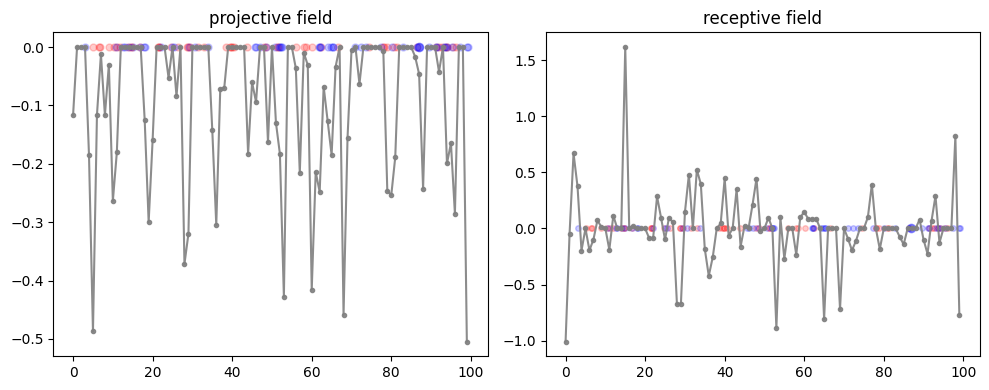

In [ ]:
if embed_model:
    ind = 10
    # k = indE[ind]
    k = indI[ind]
    # k = ind
    print("neuron:", k)
    print("sign:", signJ[k])
    color = "red" if signJ[k] > 0 else "blue"

    plt.figure(figsize=(10,4))

    plt.subplot(121)
    plt.title('projective field')
    if dim == 1:
        plt.plot(pos[indE], 0 * np.ones_like(pos[indE]), 'o', ms=5, c='red', alpha=0.2)
        plt.plot(pos[indI], 0 * np.ones_like(pos[indI]), 'o', ms=5, c='blue', alpha=0.2)
        plt.plot(pos[k], 0, 'o', c=color, alpha=0.4);
        plt.plot(J[:,k], '.-', alpha=0.9, c='gray')
    else:
        plt.plot(pos[k,1], pos[k,0], 'o', c=color);
        plt.imshow(np.abs(J[:,k]).reshape(lN,lN))

    plt.subplot(122)
    plt.title('receptive field')
    if dim == 1:
        plt.plot(pos[indE], 0 * np.ones_like(pos[indE]), 'o', ms=4, c='red', alpha=0.2)
        plt.plot(pos[indI], 0 * np.ones_like(pos[indI]), 'o', ms=4, c='blue', alpha=0.2)
        plt.plot(pos[k], 0, 'o', c=color, alpha=0.4);
        plt.plot(J[k], '.-', alpha=0.9, c='gray');
    else:
        plt.plot(pos[k,1], pos[k,0], 'o', c=color);
        plt.imshow(J[k].reshape(lN,lN));

    plt.tight_layout();

### Look at E and I populations separately

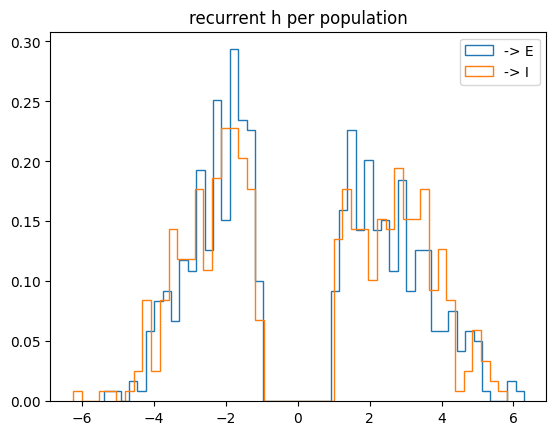

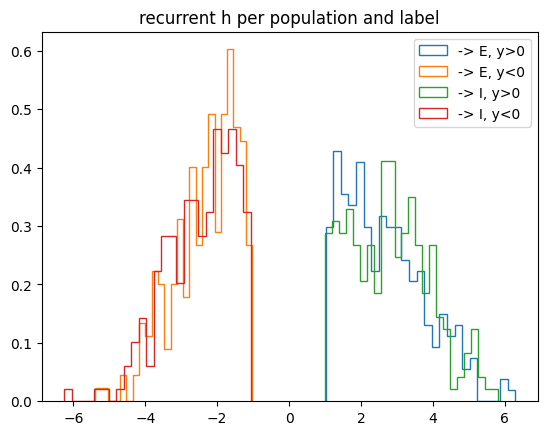

In [ ]:
# fields per population
HfromE = X[:,indE] @ J[:,indE].T
HfromI = X[:,indI] @ J[:,indI].T

plt.hist(Hs[:,indE].flatten(), bins=50, density=True, histtype="step", label='-> E');
plt.hist(Hs[:,indI].flatten(), bins=50, density=True, histtype="step", label='-> I');
plt.title('recurrent h per population')
plt.legend();
plt.show();

plt.hist(Hs[:,indE][Y[:,indE]>0].flatten(), bins=25, density=True, histtype="step", label='-> E, y>0');
plt.hist(Hs[:,indE][Y[:,indE]<0].flatten(), bins=25, density=True, histtype="step", label='-> E, y<0');
plt.hist(Hs[:,indI][Y[:,indI]>0].flatten(), bins=25, density=True, histtype="step", label='-> I, y>0');
plt.hist(Hs[:,indI][Y[:,indI]<0].flatten(), bins=25, density=True, histtype="step", label='-> I, y<0');
plt.title('recurrent h per population and label')
plt.legend();
plt.show();

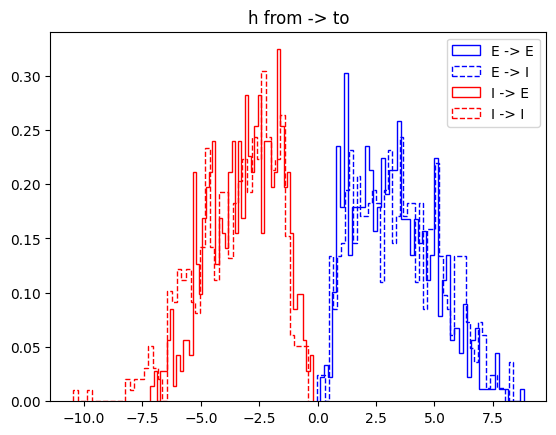

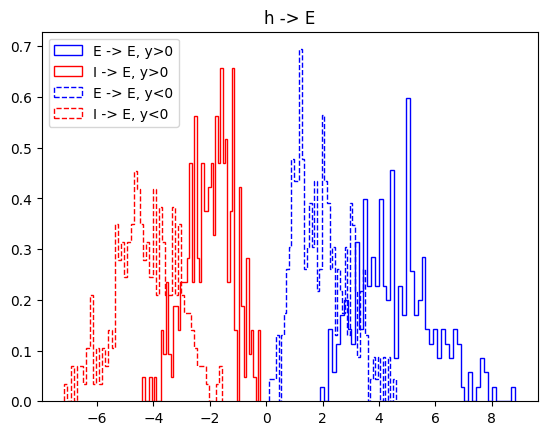

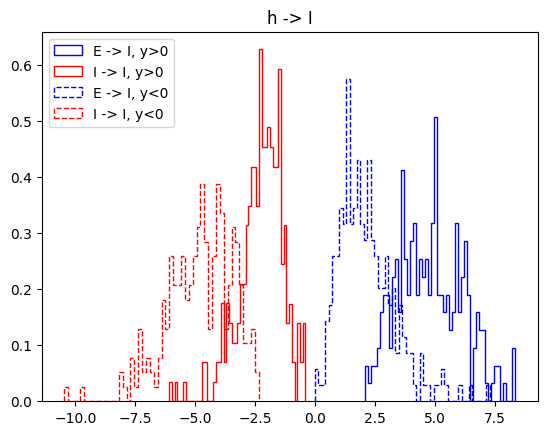

In [ ]:
# fields per channel
plt.hist(HfromE[:,indE].flatten(), bins=50, density=True, histtype="step", label='E -> E', color='blue');
plt.hist(HfromE[:,indI].flatten(), bins=50, density=True, histtype="step", label='E -> I', color='blue', ls='--');
plt.hist(HfromI[:,indE].flatten(), bins=50, density=True, histtype="step", label='I -> E', color='red');
plt.hist(HfromI[:,indI].flatten(), bins=50, density=True, histtype="step", label='I -> I', color='red', ls='--');
plt.title('h from -> to')
plt.legend();
plt.show()

## fields to E per label
plt.hist(HfromE[:,indE][Y[:,indE]>0].flatten(), bins=50, density=True, color='blue', histtype="step", label='E -> E, y>0');
plt.hist(HfromI[:,indE][Y[:,indE]>0].flatten(), bins=50, density=True, color='red', histtype="step", label='I -> E, y>0');
plt.hist(HfromE[:,indE][Y[:,indE]<0].flatten(), bins=50, density=True, color='blue', ls='--', histtype="step", label='E -> E, y<0');
plt.hist(HfromI[:,indE][Y[:,indE]<0].flatten(), bins=50, density=True, color='red', ls='--', histtype="step", label='I -> E, y<0');
plt.title('h -> E')
plt.legend();
plt.show()

## fields to I per label
plt.hist(HfromE[:,indI][Y[:,indI]>0].flatten(), bins=50, density=True, color='blue', histtype="step", label='E -> I, y>0');
plt.hist(HfromI[:,indI][Y[:,indI]>0].flatten(), bins=50, density=True, color='red', histtype="step", label='I -> I, y>0');
plt.hist(HfromE[:,indI][Y[:,indI]<0].flatten(), bins=50, density=True, color='blue', ls='--', histtype="step", label='E -> I, y<0');
plt.hist(HfromI[:,indI][Y[:,indI]<0].flatten(), bins=50, density=True, color='red', ls='--', histtype="step", label='I -> I, y<0');
plt.title('h -> I')
plt.legend();
plt.show()